In [1]:
%matplotlib inline
from __future__ import division
import numpy as np
import pandas as pd
import math as maths
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import random
import itertools
from scipy.integrate import odeint
from scipy.optimize import minimize as minimise, curve_fit

sns.set(style="white", color_codes=True)
sns.despine(trim = True)
sns.set_context('poster', font_scale = 1)
sns.set_palette("colorblind", 8) #sns colormap for graph
sigma = np.random.random(100)*0.0001
sigma[0] = 100  #sets sigma value to very high for first data point, 
#because this is the one fed into the model and therefore the one that must be fitted to.


![](model_with_spc.png)

In [2]:
int_params = [0.025094, 0.00058, 0.007144, 0.001508, 0.013426]
#initial parameter guess to feed into minimiser function
timespan = np.linspace(0,72,100) #time span for simulation
time = [0, 24, 48, 72] #time points of each data point

In [3]:
def diffeq(y, t, k0, k1, k2, k3, k4, k5):

    ''' 
    Function containing the ODEs for the model system:
    inputs:
        y - array of initial cell numbers in form [mc, gmc, stm, slgc, pc]
        t - time over which the function runs (not necessary for the equation, but is for integration with odeint)
        k0, k1, k2, k3, k4, k5, k6 - float, parameter values
    '''

    SPCi = y[0]
    STMi = y[1]
    SLGCi = y[2]
    PCi = y[3]
    #the model equations =

    f0 = (k3*SLGCi) - ((k0+k1)*SPCi)
    f1 = (k0*SPCi)
    f2 = (k1*SPCi)+(k4*PCi)-((k2+k3)*SLGCi)
    f3 = (k2*SLGCi) + ((k5-k4)*PCi)

    return [f0, f1, f2, f3]


In [4]:
def diffeqsolver(y1, t1, parameters1):

    '''
    function which passes the input from func to odeint
    inputs:
        y1 - array of initial cell numbers in form [mc, gmc, stm, slgc, pc]
        t1 - time for diffeq solver
        parameters - list of parameters to be fed to diffeqs
    '''

    parameters_tuple = tuple(parameters1)

    soln = odeint(diffeq, y1, t1, args = parameters_tuple)
    MC = soln[:, 0]
    STM = soln[:, 1]
    SLGC = soln[:, 2]
    PC = soln[:, 3]

    return [MC, STM, SLGC, PC]


In [5]:
def param_fitter(cell_counts, initial_guess):
    '''
    function to pass data through scipy.minimize (here named minimise)
    input:
        - cell counts at t0
        - initial guess of parameter values
        
    output:
        - scipy.minimise object attribute .x, which is the minimised parameter values.
    '''
    initial_guess = initial_guess
    def minimiserk7(params1):

        '''function to be minimised by the scipy minimiser.
        accepts only params, an array of the first guesses for each parameter.

        outputs the regression for the fit between a line of best fit and the model.'''

        xlist = cell_counts #cell type to be fitted to
        y1 = xlist[:][0]

        y = diffeqsolver(y1, timespan, params1)
        minval = np.zeros(len(xlist))  
        for x in range(len(xlist)):
            
            curve = np.polyfit([0, 24, 48, 72],xlist[x], 1, w = [100, 0.1, 0.1, 0.1]) #fit cell counts from data to a curve for linregress

            x2 = np.polyval(curve, timespan) #evaluate curve over timecourse

            y0 = y[x] #values from integrated ode over time

            ss=lambda data,model:((data-model)**2).sum()
            minval[x] = ss(x2, y0)
            
        return minval.sum()
    
    solution = minimise(minimiserk7, initial_guess, bounds = 
                        ((0, None),(0, None),(0, None),(0, None),(0, None),(0, None)))#, (0, None)))
    

    return solution.x

In [6]:
file_name = 'cell_population_counts_Col0_Mute_SPCH.xlsx'
dfAllCounts = pd.read_excel(open(file_name,'rb'), sheetname='test counts') #make df from spreadsheet

cond_dict = {}
conditions_dict = {}  

conditions_list = list(itertools.product(dfAllCounts.background.unique(), 
                                    dfAllCounts.growth_condition.unique(),
                                    dfAllCounts.time.unique())) 

for b,i,t in conditions_list:
    
    conditionPD = dfAllCounts[(dfAllCounts.background == b)&(dfAllCounts.time == t)
                                           &(dfAllCounts.growth_condition == i)]
    
    avgarea = np.nanmean(conditionPD.avg_cell_area.values)

    
    cond_dict[b,i,t]=np.asarray([
       (np.nanmean(conditionPD.MC.values)*avgarea)+(np.nanmean(conditionPD.GMC.values)* avgarea),
       (np.nanmean(conditionPD.Stomata.values)* avgarea),
        (np.nanmean(conditionPD.SLGC.values)* avgarea),
        (np.nanmean(conditionPD.PC.values)* avgarea)])

for b,i in list(itertools.product(dfAllCounts.background.unique(), 
                                    dfAllCounts.growth_condition.unique())):
    SPCS = [cond_dict[b, i, t][0] for t in dfAllCounts.time.unique()]
    STMS = [cond_dict[b, i, t][1] for t in dfAllCounts.time.unique()]
    SLGCS = [cond_dict[b, i, t][2] for t in dfAllCounts.time.unique()]
    PCS = [cond_dict[b, i, t][3] for t in dfAllCounts.time.unique()]
    
    conditions_dict[b,i] = [SPCS, STMS, SLGCS, PCS]
    
cell_counts = conditions_dict['Col0', 'mock']
cell_counts[:][0]

[0.15950958327642276,
 0.10023651009439201,
 0.095955365533532316,
 0.054312127640100238]

In [7]:
param_dict = {}

for b,i in list(itertools.product(dfAllCounts.background.unique(), 
                                                  dfAllCounts.growth_condition.unique())):
    int_params = np.random.random((1,6))
    parameter_values = [0.1,0.1,0.1,0.1,0.1,0.1] #int_params defined at top
    cell_counts = conditions_dict[b,i]
    fitted_params = param_fitter(cell_counts, parameter_values)
    param_dict[b,i] = fitted_params

param_df = pd.DataFrame.from_dict(param_dict)

param_df

/Users/rcdenleybowers/anaconda/lib/python3.5/site-packages/scipy/integrate/odepack.py:218: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


CYCD3;1                     Col0                   MUTE               \
           est          mock        est       mock         est         mock   
0  1575.098777  1.048363e-07   5.270285   1.180151  173.983758   347.877762   
1  2010.277006  1.023869e+01  44.327132  17.603177  327.733669   620.935951   
2     0.009997  8.684246e-03   0.000513   0.000889    0.004798     0.001019   
3     0.013729  0.000000e+00   0.034027   0.068147    0.011845     0.007746   
4  5023.200145  2.493738e+01  74.824085  10.641192  837.047408  1132.691962   
5  3557.033480  1.660076e+01  66.785577   9.047873  622.838141   939.216011   

         SPCH             
          est       mock  
0   72.161853   2.221542  
1   94.157095  10.293689  
2    0.000885   0.000624  
3    0.008764   0.028130  
4  170.999256  16.527379  
5  144.784795  14.529303

,CYCD3;1diff,Col0diff,MUTEdiff,SPCHdiff
0,1.502437e+12,346.577072,-49.987100,3148.278136
1,1.953412e+04,151.813243,-47.219408,814.706978
2,1.511548e+01,-42.323115,370.948228,41.884157
3,1.372863e+00,-50.068662,52.923933,-68.844489
4,2.004326e+04,603.155141,-26.101055,934.642304
5,2.132693e+04,638.135671,-33.685315,896.501970


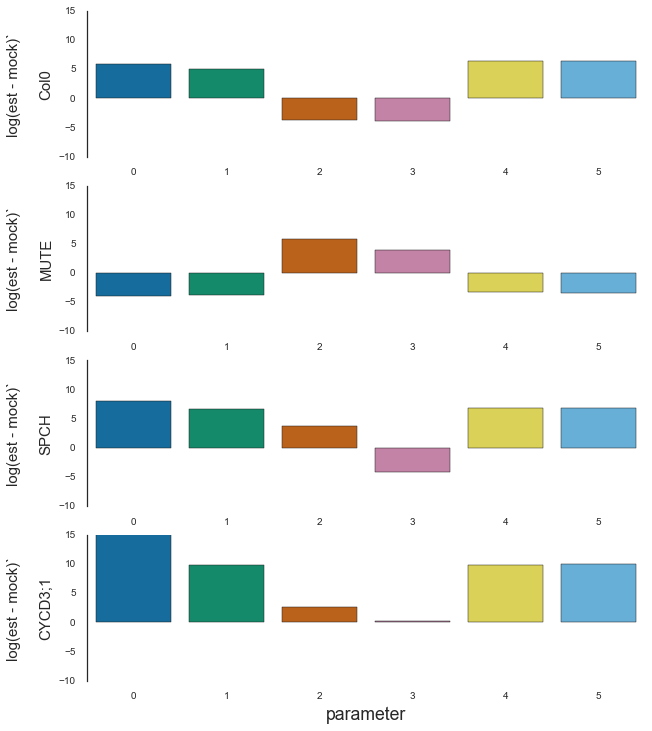

In [8]:

condition_list = np.zeros((3, 8))
j = 0
x = [0, 1, 2, 3, 4, 5]

f, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(10, 12))
axes = (ax1, ax2, ax3, ax4)
axval = 0
change_dict = {}
for condition in dfAllCounts.background.unique():
    mock = pd.DataFrame.as_matrix(param_df[condition, 'mock'])
    est = pd.DataFrame.as_matrix(param_df[condition, 'est'])
    percent_val = [est[i]*100 if mock[i] == 0 else ((est[i]-mock[i])/mock[i])*100 for i in range(len(est))]
    log_val =  [0 if x==0 else np.sign(x)*maths.fabs(maths.log(maths.fabs(x))) for x in percent_val]
    sns.barplot(x, log_val, ax = axes[axval], palette='colorblind')

    axes[axval].tick_params(labelsize= 10)
    axes[axval].set_ylim(-10,15)
    axes[axval].set_ylabel('log(est - mock)'+'`\n \n'+condition, fontsize = 15)
    axval += 1
    change_dict[condition + 'diff'] = percent_val

sns.despine(bottom=True)
#plt.tight_layout(h_pad=1)
plt.xlabel('parameter')
plt.rcParams['svg.fonttype'] = 'none'
plt.savefig('percent_difference_new.svg')
change_pd = pd.DataFrame.from_dict(change_dict)
change_pd

In [9]:
for b,i in list(itertools.product(dfAllCounts.background.unique(), 
                                  dfAllCounts.growth_condition.unique())):
    fig = plt.figure(figsize=(16,4))
    cell_counts = conditions_dict[b, i]
    sim_params = param_dict[b,i]
    initial_counts = count_list[:][0]
    print(cell_counts[:][0], '\n')
    
    axs = fig.add_subplot(1, 3, 1)
    soln = odeint(diffeq, initial_counts, timespan, args = tuple(sim_params))
    SPC = soln[:, 0]
    STM = soln[:, 1]
    SLGC = soln[:, 2]
    PC = soln[:, 3]
    resultsDf = pd.DataFrame({'time': timespan, 'SPC' : SPC, 'PC' : PC, 'SLGC' : SLGC,'STM':STM})
    resultsDf.plot(x = 'time', y = ['SPC','PC','SLGC','STM'], ax = axs)
    
    axs.set_title('Simulation: '+b+' '+i, fontsize = 20)
    axs.set_ylim(0, 0.8)
    
    '''actual data from excel spreadsheet '''
    axs1 = fig.add_subplot(1, 3, 3)
    dataDf = pd.DataFrame({'time': [0, 24, 48, 72], 
                              'SPC' : cell_counts[0][ :], 
                              'STM' : cell_counts[1][:],
                              'SLGC' : cell_counts[2][:],
                              'PC': cell_counts[3][:]})

    dataDf.plot(x = 'time', y = ['SPC', 'PC', 'SLGC', 'STM'],ax=axs1)
    axs1.set_xlabel('t')
    axs1.set_ylabel('cellCount')
    axs1.set_ylim(0, 0.8)
    axs1.set_title('Data', fontsize = 20)

    ''' lobf for data'''
    axs2 = fig.add_subplot(1, 3, 2)
    namelist = ['SPC', 'STM','SLGC','PC']
    time = [0, 24, 48, 72]  
    curve_dict = {}
    for n in range(len(cell_counts[:][0])):

        curve = np.polyfit(time, cell_counts[n], 1)#, w=[100, 0.1, 0.1, 0.1])
        x2 = np.polyval(curve, timespan)
        curve_dict[namelist[n]] = x2
    fit_df = pd.DataFrame.from_dict(curve_dict)
    fit_df.plot(x = timespan, y = ['SPC', 'PC', 'SLGC', 'STM'],ax=axs2)
    axs2.set_title('LOBF', fontsize = 20)
    axs2.set_ylim(0, 0.8)
    
    plt.rcParams['svg.fonttype'] = 'none'
    plt.savefig('k7_fitting'+b+i+'_nuevos.svg')
    sns.despine()

NameError: name 'count_list' is not defined